# Implementing TradingView's Stochastic RSI indicator in Python

## Configuring your development environment

In [1]:
# install the required python packages
# !pip install numpy pandas yfinance matplotlib mplfinance seaborn

## Implementing TradingView's Stochastic RSI indicator

In [2]:
# import the necessary packages
from dataclasses import dataclass
from datetime import timedelta
from datetime import datetime
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import numpy as np

In [3]:
@dataclass(frozen=True)
class StochasticRSIComputation:
    # define the data schema for stochastic RSI, including the raw values,
    # K-line, and D-line
    stoch_rsi: pd.Series
    k_line: pd.Series
    d_line: pd.Series

In [4]:
def stochastic_rsi(
        series: pd.Series,
        period: int = 14,
        k_smooth: int = 3,
        d_smooth: int = 3
) -> StochasticRSIComputation:
    # check to see if an invalid period value was supplied
    if period <= 0 or period >= len(series):
        # raise an error
        raise ValueError(
            f"Period must be greater than 0 and less than the length of the "
            f"series (got period={period}, data length={len(series)})"
        )

    # calculate the price changes between consecutive periods, dropping any NA
    # rows
    delta = series.diff().dropna()

    # initialize two series, one for price increases (ups) and another for
    # decreases (downs)
    ups = pd.Series(np.zeros(len(delta)), index=delta.index)
    downs = ups.copy()

    # fill the ups with positive price changes and the downs with absolute
    # value of negative price changes
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = np.absolute(delta[delta < 0])

    # set the first usable value as the average of the gains, removing the
    # first period minus one values that aren't used
    ups[ups.index[period - 1]] = np.mean(ups[:period])
    ups = ups.drop(ups.index[:period - 1])

    # do the same for the downs, setting the first usable value as the average
    # of initial losses, removing any values that were not computed for a full
    # period worth of data
    downs[downs.index[period - 1]] = np.mean(downs[:period])
    downs = downs.drop(downs.index[:period - 1])

    # compute the exponential moving average of the ups
    ups_ewm = ups.ewm(
        com=period - 1,
        min_periods=0,
        adjust=False,
        ignore_na=False
    ).mean()

    # do the same for the downs
    downs_ewm = downs.ewm(
        com=period - 1,
        min_periods=0,
        adjust=False,
        ignore_na=False
    ).mean()

    # compute the relative strength (RS) as the average gains divided by the
    # average losses, then construct the relative strength index (RSI) by
    # scaling RS to the range [0, 100]
    rs = ups_ewm / downs_ewm
    rsi = 100 - (100 / (1.0 + rs))

    # compute the stochastic RSI values using min-max scaling across the period
    rsi_min = rsi.rolling(period).min()
    rsi_max = rsi.rolling(period).max()
    stoch_rsi = (rsi - rsi_min) / (rsi_max - rsi_min)

    # construct two smoothed values, including (1) the K-line, which is a
    # smoothing of the raw stochastic RSI values, and (2) the D-line which
    # is a smoothing of the K-line
    k_line = stoch_rsi.rolling(k_smooth).mean()
    d_line = k_line.rolling(d_smooth).mean()

    # construct and return the stochastic RSI values (note that these values
    # should be *very similar* to TradingView's implementation)
    return StochasticRSIComputation(
        stoch_rsi=stoch_rsi,
        k_line=k_line,
        d_line=d_line
    )

## Exploring our Stochastic RSI implementation 

In [5]:
# set the name of the ticker we want to download market data for
ticker = "RSI"

# set the start and end data for the history request
end_date = datetime(year=2025, month=3, day=1)
start_date = end_date - timedelta(days=250)

In [6]:
# download OHLCV market data for the ticker
df = yf.download(
    tickers=ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    auto_adjust=True,
    progress=False
)

# restructure the default multi-index dataframe to our preferred format
df = df.stack(level="Ticker", future_stack=True)
df.index.names = ["Date", "Symbol"]
df = df[["Open", "High", "Low", "Close", "Volume"]]
df = df.swaplevel(0, 1)
df = df.sort_index()
df.tail()

Price               Open    High     Low  Close   Volume
Symbol Date                                             
RSI    2025-02-24  13.65  13.870  13.103  13.23  2139000
       2025-02-25  13.09  13.210  12.630  12.89  2186700
       2025-02-26  13.14  13.730  13.140  13.30  2154600
       2025-02-27  12.50  12.562  11.160  11.27  7272800
       2025-02-28  11.50  11.790  11.200  11.66  3925800

In [7]:
# compute the daily 50MA
df["50MA"] = df.groupby(level="Symbol")["Close"].transform(
    lambda x: x.rolling(window=50).mean()
)

### Computing Stochastic RSI on market data

In [8]:
# compute TradingView's stochastic RSI indicator on the market data
stoch_result = stochastic_rsi(df.xs(ticker)["Close"])

In [9]:
# set the location index into the dataframe to be the ticker and computed
# k-line index values
idx = (ticker, stoch_result.k_line.index)

# add the k-line and d-line values to the dataframe
df.loc[idx, "KLine"] = stoch_result.k_line.values
df.loc[idx, "DLine"] = stoch_result.d_line.values

# drop any NaN rows from the dataframe (caused by computing the MA and
# stochastic RSI values)
df = df.dropna()
df

Price               Open    High     Low  Close   Volume     50MA     KLine  \
Symbol Date                                                                   
RSI    2024-09-03   9.19   9.240   8.990   9.02  1466200   9.4758  0.627819   
       2024-09-04   9.04   9.420   8.924   9.18  1323500   9.4732  0.685669   
       2024-09-05   9.16   9.320   8.985   9.10  1351300   9.4692  0.535517   
       2024-09-06   9.10   9.210   8.930   9.08   973200   9.4638  0.586065   
       2024-09-09   9.17   9.530   9.140   9.39  1494800   9.4616  0.686873   
...                  ...     ...     ...    ...      ...      ...       ...   
       2025-02-24  13.65  13.870  13.103  13.23  2139000  14.3368  0.114241   
       2025-02-25  13.09  13.210  12.630  12.89  2186700  14.3246  0.000000   
       2025-02-26  13.14  13.730  13.140  13.30  2154600  14.3134  0.038610   
       2025-02-27  12.50  12.562  11.160  11.27  7272800  14.2654  0.038610   
       2025-02-28  11.50  11.790  11.200  11.66  3925800  14.2272  0.066729   

Price                 DLine  
Symbol Date                  
RSI    2024-09-03  0.491664  
       2024-09-04  0.609470  
       2024-09-05  0.616335  
       2024-09-06  0.602417  
       2024-09-09  0.602818  
...                     ...  
       2025-02-24  0.268915  
       2025-02-25  0.118716  
       2025-02-26  0.050950  
       2025-02-27  0.025740  
       2025-02-28  0.047983  

[123 rows x 8 columns]

## Plotting Stochastic RSI indicator

In [10]:
# construct additional plots
addt_plots = [
    # plot the 50MA
    mpf.make_addplot(
        df.xs(ticker)["50MA"],
        color="blue",
        width=1.5,
        label="50MA"
    ),

    # plot the stochastic RSI k-line
    mpf.make_addplot(
        df.xs(ticker)["KLine"],
        panel=1,
        color="blue",
    ),

    # plot the stochastic RSI d-line
    mpf.make_addplot(
        df.xs(ticker)["DLine"],
        panel=1,
        color="orange",
    ),

    # plot the oversold line
    mpf.make_addplot(
        [0.2] * len(df.xs(ticker)),
        panel=1,
        color="red",
        linestyle="--"
    ),

    # plot the undersold line
    mpf.make_addplot(
        [0.8] * len(df.xs(ticker)),
        panel=1,
        color="green",
        linestyle="--"
    ),
]

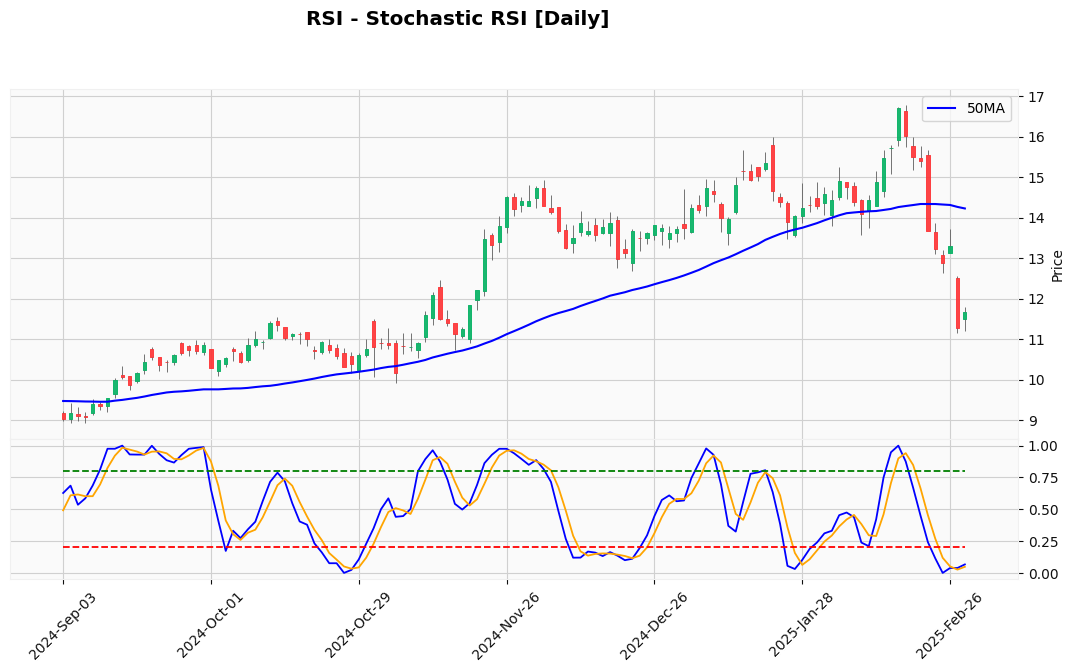

In [11]:
# plot the daily OHLCV bars, MA, and stochastic RSI
mpf.plot(
    df.xs(ticker),
    type="candle",
    style="yahoo",
    addplot=addt_plots,
    figsize=(14, 7),
    title=f"{ticker} - Stochastic RSI [Daily]"
)